In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score, confusion_matrix
import os
import re
from wordcloud import WordCloud

In [26]:
os.chdir('../../..')

In [37]:
data = pd.read_csv("C:/Users/Koen-PC/Desktop/Actueel school/text mining/spam.csv", encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [38]:
data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
data.rename(columns=dict(v1="label", v2="text"), inplace=True)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [39]:
data['text_processed'] = data['text'].map(lambda x: re.sub('[,\.!?]', '', x))
data['text_processed'] = data['text_processed'].map(lambda x: x.lower())
data.head()

,label,text,text_processed
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives arou...


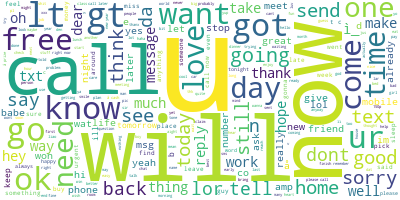

In [40]:
from wordcloud import WordCloud
long_string = ','.join(list(data['text_processed'].values))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [41]:
train = data.loc[:(int(0.8*len(data)))]
test = data.loc[(int(0.8*len(data))):]

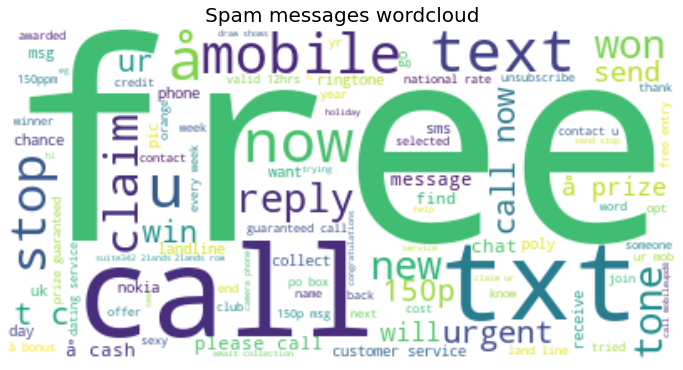

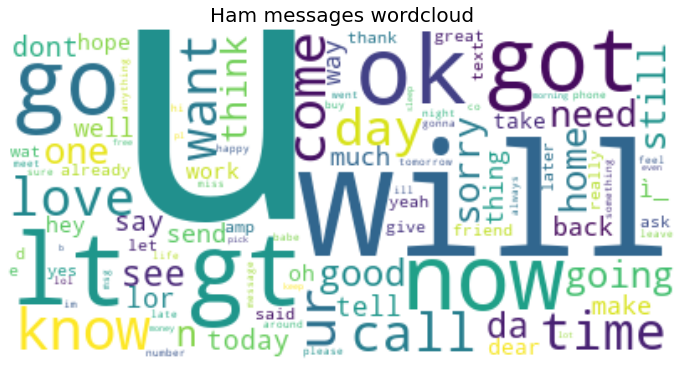

In [42]:
def text_for_cloud(label):
    text = ' '.join(train['text_processed'][train['label'] == label].to_list())
    text = text.replace('somenumbers', '')
    return text

for label in ['spam', 'ham']:
    wordcloud = WordCloud(
        max_font_size=500,
        max_words=100,
        background_color="white"
    ).generate(text_for_cloud(label))

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'{label.capitalize()} messages wordcloud', fontsize=20)
    plt.show()

In [16]:
vectorizer = CountVectorizer(stop_words="english", 
                             ngram_range=(1, 3))
term_document_matrix = vectorizer.fit_transform(train.text_processed)
corpus = Sparse2Corpus(term_document_matrix, documents_columns=False)
id2word = {value: key for key, value in vectorizer.vocabulary_.items()}
model = LdaModel(corpus=corpus, 
                 id2word=id2word, 
                 random_state=0)

def transform_text_to_topic_vectors(data, vectorizer, model):
    num_topics = model.num_topics
    text_topics = pd.DataFrame(index=map(str, range(num_topics)))    
    for index, text in data.text_processed.iteritems():
        text_transformed = (vectorizer.transform([text]))
        text_corpus = (Sparse2Corpus(text_transformed, documents_columns=False))
        topics_framework = dict.fromkeys(map(str, range(0, num_topics)))
        topics_specific = dict(list(model[text_corpus])[0])
        for key in topics_specific:
            topics_framework[str(key)] = topics_specific[key]
        text_topics[index] = pd.Series(topics_framework)
    text_topics = text_topics.T.fillna(0)
    data = data.join(text_topics)
    data.drop(["text", "text_processed"], axis=1, inplace=True)
    data = pd.get_dummies(data, drop_first=True)
    data.rename(columns=dict(Class_spam="Spam"), inplace=True)
    return data

train = transform_text_to_topic_vectors(train, vectorizer, model)
test = transform_text_to_topic_vectors(test, vectorizer, model)
train.head()

C:\Users\Koen-PC\AppData\Local\Temp/ipykernel_1656/747076228.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  text_topics[index] = pd.Series(topics_framework)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label_spam
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.026174,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0


In [43]:
vectorizer = CountVectorizer(stop_words="english", 
                             ngram_range=(1, 3))
term_document_matrix = vectorizer.fit_transform(train.text_processed)
corpus = Sparse2Corpus(term_document_matrix, documents_columns=False)
id2word = {value: key for key, value in vectorizer.vocabulary_.items()}
model = LdaModel(corpus=corpus, 
                 id2word=id2word, 
                 random_state=0)

def transform_messages_to_topic_vectors(data, vectorizer, model):
    num_topics = model.num_topics
    message_topics = pd.DataFrame(index=map(str, range(num_topics)))    
    for index, message in data.text_processed.iteritems():
        message_transformed = (vectorizer.transform([message]))
        message_corpus = (Sparse2Corpus(message_transformed, documents_columns=False))
        topics_framework = dict.fromkeys(map(str, range(0, num_topics)))
        topics_specific = dict(list(model[message_corpus])[0])
        for key in topics_specific:
            topics_framework[str(key)] = topics_specific[key]
        message_topics[index] = pd.Series(topics_framework)
    message_topics = message_topics.T.fillna(0)
    data = data.join(message_topics)
    data.drop("text_processed", axis=1, inplace=True)
    data.drop("text", axis=1, inplace=True)
    data = pd.get_dummies(data, drop_first=True)
    data.rename(columns=dict(Class_spam="label_spam"), inplace=True)
    return data

train = transform_messages_to_topic_vectors(train, vectorizer, model)
test = transform_messages_to_topic_vectors(test, vectorizer, model)
train.head()

C:\Users\Koen-PC\AppData\Local\Temp/ipykernel_1656/1466112700.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  message_topics[index] = pd.Series(topics_framework)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label_spam
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.026174,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0


F:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


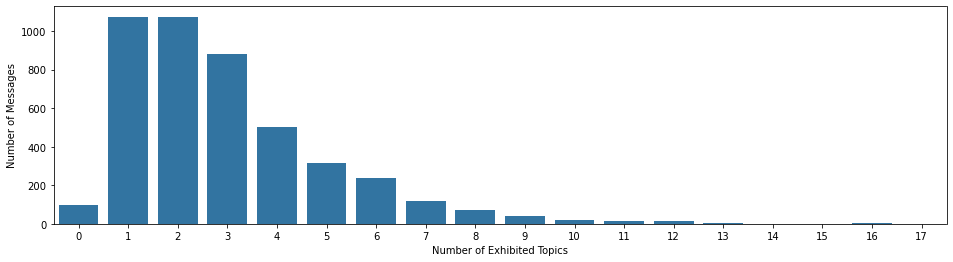

In [44]:
topics = list(train.columns)
topics.remove("label_spam")
ax = sns.countplot(train[topics].astype(bool).sum(axis=1), color="C0")
ax.set_xlabel("Number of Exhibited Topics")
ax.set_ylabel("Number of Messages")
fig = plt.gcf()
fig.set_size_inches(16, 4)